Found 41276 files belonging to 2 classes.
Using 33021 files for training.
Found 41276 files belonging to 2 classes.
Using 8255 files for validation.


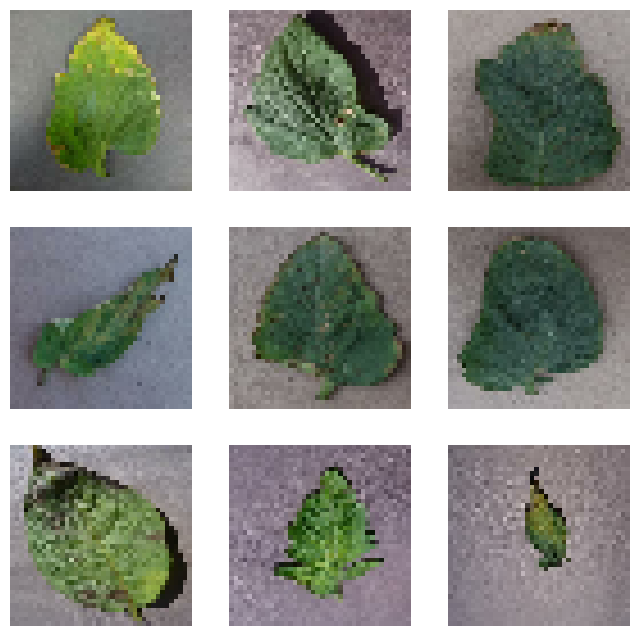

Epoch 1/5
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5020 - loss: 0.6949

2064/2064 ━━━━━━━━━━━━━━━━━━━━ 3616s 2s/step - accuracy: 0.5020 - loss: 0.6949 - val_accuracy: 0.5031 - val_loss: 0.6931
Epoch 2/5
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 3620s 2s/step - accuracy: 0.5012 - loss: 0.6933 - val_accuracy: 0.4969 - val_loss: 0.6932
Epoch 3/5
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 3648s 2s/step - accuracy: 0.4956 - loss: 0.6933 - val_accuracy: 0.5031 - val_loss: 0.6931
Epoch 4/5
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 3579s 2s/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5031 - val_loss: 0.6931
Epoch 5/5
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 3595s 2s/step - accuracy: 0.4964 - loss: 0.6931 - val_accuracy: 0.4969 - val_loss: 0.6933
516/516 ━━━━━━━━━━━━━━━━━━━━ 148s 287ms/step - accuracy: 0.5116 - loss: 0.6930
Test Accuracy: 50.31%


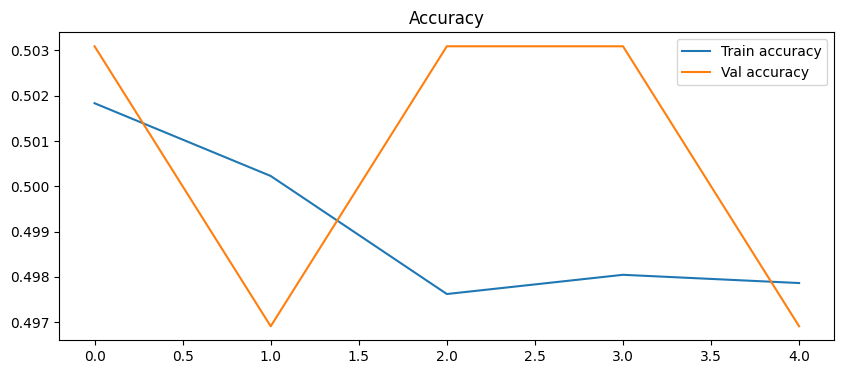

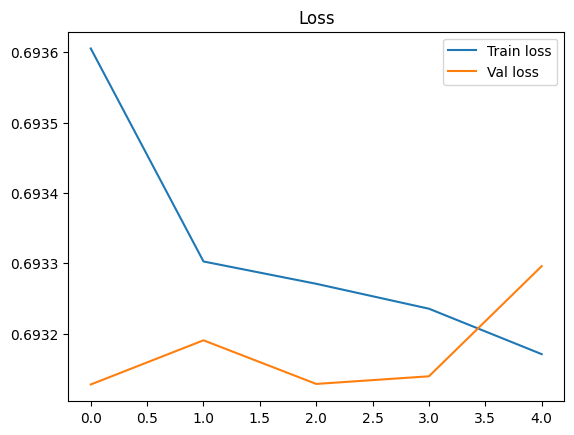

In [2]:
import kagglehub
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Download dataset from Kaggle
dataset_path = kagglehub.dataset_download("emmarex/plantdisease")

# Load dataset with smaller batch size and reduced image size
img_size, batch_size = (40, 40), 16  # Reduced image size and batch size
train_ds = image_dataset_from_directory(dataset_path, validation_split=0.2, subset="training", seed=42,
                                        image_size=img_size, batch_size=batch_size)
test_ds = image_dataset_from_directory(dataset_path, validation_split=0.2, subset="validation", seed=42,
                                       image_size=img_size, batch_size=batch_size)

# Extract class names
class_names = train_ds.class_names  # This will give the list of class names

# Normalize & optimize data loading
train_ds = train_ds.map(lambda x, y: (x / 255.0, y)).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)).prefetch(tf.data.experimental.AUTOTUNE)

# Display sample images
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
plt.show()

# Define AlexNet-inspired model
def create_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tfl.RandomFlip("horizontal")(inputs)
    x = tfl.RandomRotation(0.2)(x)
    for filters in [96, 256, 384, 384, 256]:
        x = tfl.Conv2D(filters, 3, activation='relu', padding='same')(x)
        if filters in [96, 256]: x = tfl.MaxPool2D(3, 2, padding='same')(x)
    x = tfl.Flatten()(x)
    for units in [4096, 4096, 1000]:
        x = tfl.Dense(units, activation='relu')(x)
        x = tfl.Dropout(0.4)(x)
    outputs = tfl.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Compile and train model
model = create_model((40, 40, 3), len(class_names))  # Use len(class_names) for the number of classes
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, epochs=5, validation_data=test_ds,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)])

# Evaluate & visualize performance
model.load_weights("best_model.h5")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

plt.figure(figsize=(10, 4))
for metric in ["accuracy", "loss"]:
    plt.plot(history.history[metric], label=f"Train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}")
    plt.title(metric.capitalize())
    plt.legend()
    plt.show()